## Meteorological data analysis for Delhi (SRFP 2021)

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import scipy.stats as stats
from descartes import PolygonPatch
import statsmodels.api as sm

from windrose import WindroseAxes
from windrose import WindAxes
from windrose import plot_windrose
import matplotlib.cm as cm
import matplotlib.dates as mdates

# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [2]:
from functions import dplot, qqplot, rplot, stat_calc

In [3]:
dfnov = pd.read_csv('./data/met_data_nov_utc.csv')
dfdec = pd.read_csv('./data/met_data_dec_utc.csv')
dfjan = pd.read_csv('./data/met_data_jan_utc.csv')

In [4]:
dfnov.head()

,date,hour,mod_temp,obs_temp,mod_wd,obs_wd,mod_ws,obs_ws,mod_swdown,obs_swlower,obs_swupper
0,2020-11-3,9:00:00,30.50861,28.81444,NaN,308.13890,1.75760,4.513278,0.00000,75.140,452.300
1,2020-11-3,10:00:00,30.16214,28.72625,NaN,321.01250,4.75277,3.983250,380.66110,52.560,284.700
2,2020-11-3,11:00:00,29.53625,27.90080,NaN,320.15200,3.71238,2.345093,174.24031,19.560,74.820
3,2020-11-3,12:00:00,28.43674,26.85611,NaN,152.76110,3.51142,2.113319,6.66098,9.130,8.840
4,2020-11-3,13:00:00,27.59320,25.19833,NaN,74.14445,1.84325,1.242681,0.00000,6.859,0.391


In [5]:
dfdec.head()

,time,mod_temp,obs_temp,mod_wd,obs_wd,mod_ws,obs_ws,mod_swdown,obs_swlower,obs_swupper
0,12/1/2020 0:00:00,16.35733,13.36347,248.06122,274.7847,1.47951,1.486333,0.00000,4.649,-2.333
1,12/1/2020 1:00:00,16.04544,12.92195,251.86467,255.9778,1.42542,0.880125,0.00000,4.458,-0.119
2,12/1/2020 2:00:00,15.97870,13.14375,253.92874,263.9764,1.24226,1.098139,35.57781,9.950,40.920
3,12/1/2020 3:00:00,17.47351,14.14000,255.25107,281.9695,1.29906,1.502556,203.14876,21.760,164.200
4,12/1/2020 4:00:00,19.46429,16.18889,268.71393,266.4000,1.23652,1.776250,382.20981,34.140,314.500


In [6]:
dfjan.head()

,datetime,mod_temp,obs_temp,mod_wd,obs_wd,mod_ws,obs_ws,mod_swdown,obs_swlower,obs_swupper,obs_lwupper,obs_lwlower
0,2021-01-01 0:00:00,NaN,6.682222,NaN,79.756946,NaN,0.900347,NaN,3.510417,-0.786550,618.516667,620.381667
1,2021-01-01 1:00:00,NaN,6.623194,NaN,107.330557,NaN,1.106306,NaN,4.742067,15.913250,615.495000,617.031667
2,2021-01-01 2:00:00,NaN,7.471944,NaN,112.248613,NaN,0.464417,NaN,12.202367,106.011333,587.153333,589.123333
3,2021-01-01 3:00:00,NaN,10.370833,NaN,104.988888,NaN,0.823708,NaN,23.618167,257.441667,524.011667,544.338333
4,2021-01-01 4:00:00,NaN,13.849861,NaN,138.116665,NaN,1.378944,NaN,37.442667,379.663333,458.161667,504.655000


In [7]:
dfnov['datetime'] = pd.to_datetime(dfnov.date) + pd.to_timedelta(dfnov.hour)
dfdec['datetime'] = pd.to_datetime(dfdec.time)
dfjan['datetime'] = pd.to_datetime(dfjan.datetime)

In [8]:
dfnov = dfnov.set_index(dfnov.datetime)
dfdec = dfdec.set_index(dfdec.datetime)
dfjan = dfjan.set_index(dfjan.datetime)

dfnov.drop(['date', 'hour', 'datetime'], axis=1, inplace=True)
dfdec.drop(['time', 'datetime'], axis=1, inplace=True)
dfjan.drop(['datetime'], axis=1, inplace=True)

In [9]:
# Add the missing values of datetime in November and December as NaN

idx_nov = pd.date_range('2020-11-01 00:00:00','2020-11-30 23:00:00', freq='H')
idx_dec = pd.date_range('2020-12-01 00:00:00','2020-12-31 23:00:00', freq='H')

dfnov = dfnov.reindex(idx_nov, fill_value=np.nan)
dfdec = dfdec.reindex(idx_dec, fill_value=np.nan)

In [10]:
dfnov.loc["2020-11-03 9:00:00"]

mod_temp        30.508610
obs_temp        28.814440
mod_wd                NaN
obs_wd         308.138900
mod_ws           1.757600
obs_ws           4.513278
mod_swdown       0.000000
obs_swlower     75.140000
obs_swupper    452.300000
Name: 2020-11-03 09:00:00, dtype: float64

In [11]:
# Set 9UTC values to NaN
dfnov.loc[dfnov.index.hour == 9, 'mod_swdown'] = np.nan
dfnov.loc[dfnov.index.hour == 9, 'mod_ws'] = np.nan
dfnov.loc[dfnov.index.hour == 9, 'mod_wd'] = np.nan

dfdec.loc[dfdec.index.hour == 9, 'mod_swdown'] = np.nan
dfdec.loc[dfdec.index.hour == 9, 'mod_ws'] = np.nan
dfdec.loc[dfdec.index.hour == 9, 'mod_wd'] = np.nan

dfjan.loc[dfjan.index.hour == 9, 'mod_swdown'] = np.nan
dfjan.loc[dfjan.index.hour == 9, 'mod_ws'] = np.nan
dfjan.loc[dfjan.index.hour == 9, 'mod_wd'] = np.nan

In [12]:
### Interpolate the data

# dfnov = dfnov.interpolate(method='cubic')
# dfdec = dfdec.interpolate(method='cubic')
# dfjan = dfjan.interpolate(method='cubic')

In [13]:
df = pd.concat([dfnov, dfdec, dfjan], axis=0)

In [14]:
# # Instead set 9UTC values to average of 8UTC and 10UTC values 
# df.loc[df.index.hour == 9, 'mod_swdown'] = (df.loc[df.index.hour == 8, 'mod_swdown'] + df.loc[df.index.hour == 10, 'mod_swdown']) / 2

# df.loc[df.index.hour == 9, 'mod_ws'] = (df.loc[df.index.hour == 8, 'mod_ws'] + df.loc[df.index.hour == 10, 'mod_ws']) / 2

# df.loc[df.index.hour == 9, 'mod_wd'] = (df.loc[df.index.hour == 8, 'mod_wd'] + df.loc[df.index.hour == 10, 'mod_wd']) / 2

In [15]:
df.shape

(2208, 11)

In [16]:
df.to_csv('./data/met_data_cleaned.csv')

## Plotting

### Temperature

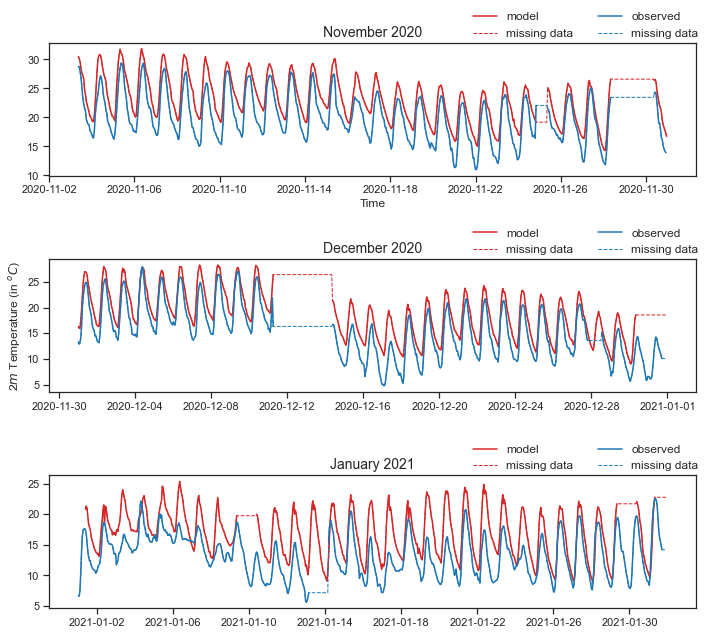

In [17]:
# Plot of Temperature (2m) for Nov, Dec, Jan

fig = plt.figure(figsize=(10,9))
plt.subplot(311)
plt.plot(dfnov.index, dfnov['mod_temp'], label='model', color='tab:red')
plt.plot(dfnov.index, dfnov['mod_temp'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfnov.index, dfnov['obs_temp'], label='observed', color='tab:blue')
plt.plot(dfnov.index, dfnov['obs_temp'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
# plt.ylabel('2$m$ Temperature (in $^{o}C$)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.title('November 2020', fontsize=14)

plt.subplot(312)
plt.plot(dfdec.index, dfdec['mod_temp'], label='model', color='tab:red')
plt.plot(dfdec.index, dfdec['mod_temp'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfdec.index, dfdec['obs_temp'], label='observed', color='tab:blue')
plt.plot(dfdec.index, dfdec['obs_temp'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
plt.ylabel('2$m$ Temperature (in $^{o}C$)', fontsize=12)
# plt.xlabel('Time', fontsize=14)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.title('December 2020', fontsize=14)

plt.subplot(313)
plt.plot(dfjan.index, dfjan['mod_temp'], label='model', color='tab:red')
plt.plot(dfjan.index, dfjan['mod_temp'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfjan.index, dfjan['obs_temp'], label='observed', color='tab:blue')
plt.plot(dfjan.index, dfjan['obs_temp'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
# plt.ylabel('2$m$ Temperature (in $^{o}C$)', fontsize=12)
# plt.xlabel('Time', fontsize=12)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.title('January 2021', fontsize=14)

# fig.suptitle('2$m$ Temperature in Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/temp.pdf', dpi=300)

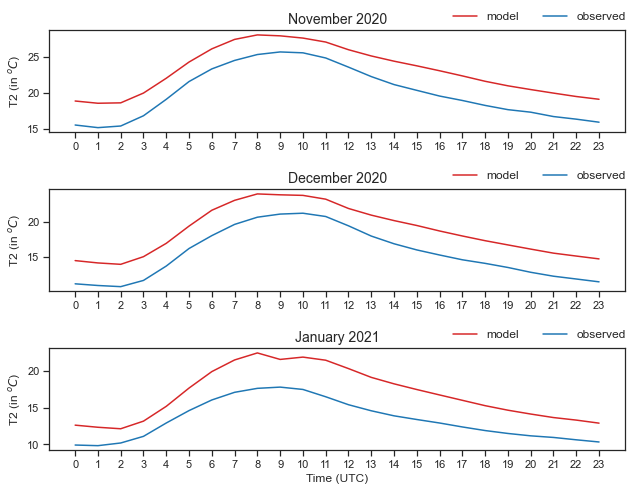

In [61]:
# Diurnal variation

fig = plt.figure(figsize=(9,7))

# plt.subplot(411)
# dplot.plot(df, df, 'mod_temp', 'obs_temp')
# # plt.ylabel('Temperature', fontsize=14)
# # plt.xlabel('Time (in hrs)', fontsize=14)
# plt.title('NDJ Combined', fontsize=12)

plt.subplot(311)
dplot.plot(dfnov, dfnov, 'mod_temp', 'obs_temp')
plt.ylabel('T2 (in $^{o}C$)', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=14)
plt.title('November 2020', fontsize=14)

plt.subplot(312)
dplot.plot(dfdec, dfdec, 'mod_temp', 'obs_temp')
plt.ylabel('T2 (in $^{o}C$)', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=14)
plt.title('December 2020', fontsize=14)

plt.subplot(313)
dplot.plot(dfjan, dfjan, 'mod_temp', 'obs_temp')
plt.ylabel('T2 (in $^{o}C$)', fontsize=12)
plt.xlabel('Time (UTC)', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Temperature at 2$m$ (in $^{o}C$) over Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/diurnal_temp.pdf', dpi=300)

### Wind Speed

In [17]:
# Calculation of WS and WD for Nov, Dec, Jan

dfnov['mod_zonal_wind'] = dfnov['mod_ws'] * (np.sin((np.pi/180)*dfnov['mod_wd']))
dfnov['mod_meridional_wind'] = dfnov['mod_ws'] * (np.cos((np.pi/180)*dfnov['mod_wd']))
dfnov['obs_zonal_wind'] = dfnov['obs_ws'] * (np.sin((np.pi/180)*dfnov['obs_wd']))
dfnov['obs_meridional_wind'] = dfnov['obs_ws'] * (np.cos((np.pi/180)*dfnov['obs_wd']))

dfdec['mod_zonal_wind'] = dfdec['mod_ws'] * (np.sin((np.pi/180)*dfdec['mod_wd']))
dfdec['mod_meridional_wind'] = dfdec['mod_ws'] * (np.cos((np.pi/180)*dfdec['mod_wd']))
dfdec['obs_zonal_wind'] = dfdec['obs_ws'] * (np.sin((np.pi/180)*dfdec['obs_wd']))
dfdec['obs_meridional_wind'] = dfdec['obs_ws'] * (np.cos((np.pi/180)*dfdec['obs_wd']))

dfjan['mod_zonal_wind'] = dfjan['mod_ws'] * (np.sin((np.pi/180)*dfjan['mod_wd']))
dfjan['mod_meridional_wind'] = dfjan['mod_ws'] * (np.cos((np.pi/180)*dfjan['mod_wd']))
dfjan['obs_zonal_wind'] = dfjan['obs_ws'] * (np.sin((np.pi/180)*dfjan['obs_wd']))
dfjan['obs_meridional_wind'] = dfjan['obs_ws'] * (np.cos((np.pi/180)*dfjan['obs_wd']))

In [18]:
df = pd.concat([dfnov, dfdec, dfjan], axis=0)

In [19]:
dfnov.tail()

,mod_temp,obs_temp,mod_wd,obs_wd,mod_ws,obs_ws,mod_swdown,obs_swlower,obs_swupper,mod_zonal_wind,mod_meridional_wind,obs_zonal_wind,obs_meridional_wind
2020-11-30 19:00:00,18.75638,15.13005,236.81689,241.8534,1.30697,0.301540,0.0,4.078,1.030,-1.093837,-0.715326,-0.265881,-0.142245
2020-11-30 20:00:00,18.29080,14.59389,235.96709,225.8611,1.45559,0.487917,0.0,3.804,0.937,-1.206271,-0.814649,-0.350155,-0.339785
2020-11-30 21:00:00,17.77780,14.18430,243.52698,273.3250,1.66242,0.650542,0.0,5.002,0.066,-1.488106,-0.741068,-0.649447,0.037731
2020-11-30 22:00:00,17.23276,13.96889,246.77043,250.8000,1.68462,0.632292,0.0,4.403,0.442,-1.548051,-0.664441,-0.597121,-0.207940
2020-11-30 23:00:00,16.74167,NaN,246.57153,NaN,1.59641,NaN,0.0,NaN,NaN,-1.464797,-0.634739,NaN,NaN


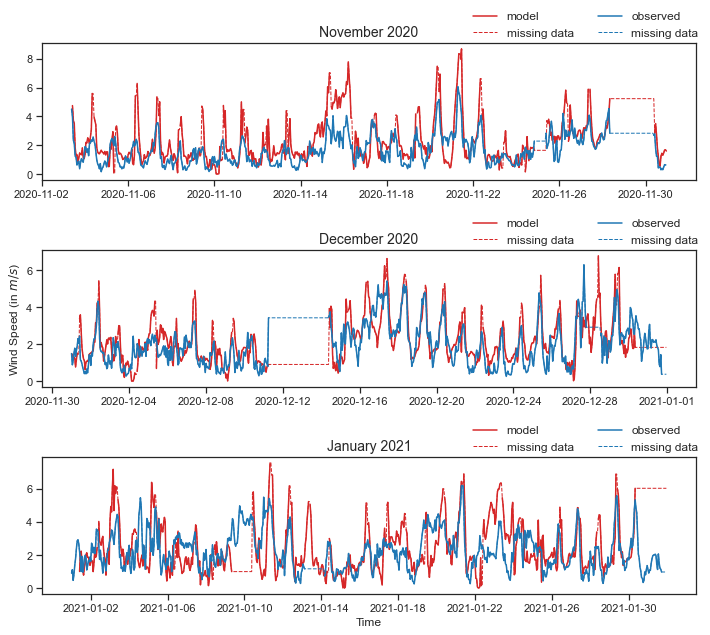

In [22]:
## Plot wind speed overall for 3 months

# Plot of wind speed (2m) for Nov, Dec, Jan

fig = plt.figure(figsize=(10,9))
plt.subplot(311)
plt.plot(dfnov.index, dfnov['mod_ws'], label='model', color='tab:red', ls='solid')
plt.plot(dfnov.index, dfnov['mod_ws'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfnov.index, dfnov['obs_ws'], label='observed', color='tab:blue')
plt.plot(dfnov.index, dfnov['obs_ws'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
# plt.ylabel('Wind Speed (in $m/s$)', fontsize=12)
# plt.xlabel('Time', fontsize=12)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.title('November 2020', fontsize=14)

plt.subplot(312)
plt.plot(dfdec.index, dfdec['mod_ws'], label='model', color='tab:red', ls='solid')
plt.plot(dfdec.index, dfdec['mod_ws'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfdec.index, dfdec['obs_ws'], label='observed', color='tab:blue')
plt.plot(dfdec.index, dfdec['obs_ws'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
plt.ylabel('Wind Speed (in $m/s$)', fontsize=12)
# plt.xlabel('Time', fontsize=14)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.title('December 2020', fontsize=14)

plt.subplot(313)
plt.plot(dfjan.index, dfjan['mod_ws'], label='model', color='tab:red', ls='solid')
plt.plot(dfjan.index, dfjan['mod_ws'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfjan.index, dfjan['obs_ws'], label='observed', color='tab:blue')
plt.plot(dfjan.index, dfjan['obs_ws'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
# plt.ylabel('Wind Speed (in $m/s$)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.title('January 2021', fontsize=14)

# fig.suptitle('Wind Speed in Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/ws.pdf', dpi=300)

### Distribution of zonal and meridional wind

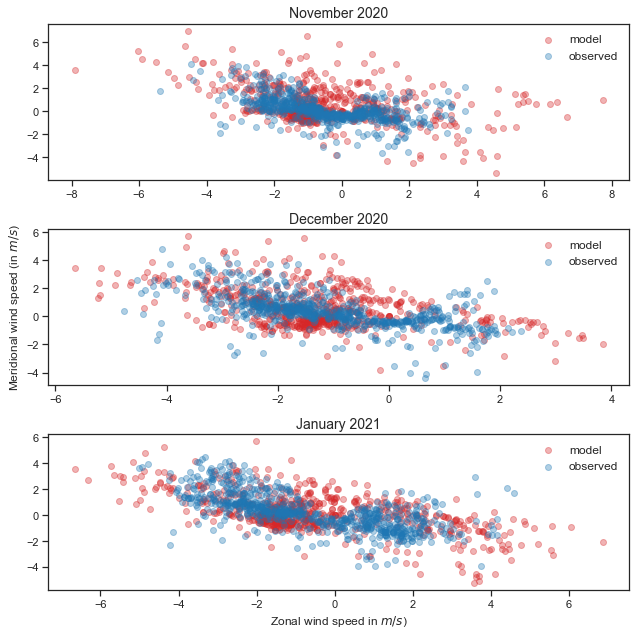

In [23]:
fig = plt.figure(figsize=(9,9))

plt.subplot(311)
plt.scatter(dfnov['mod_zonal_wind'], dfnov['mod_meridional_wind'],color='tab:red', alpha=0.35, label='model')
plt.scatter(dfnov['obs_zonal_wind'], dfnov['obs_meridional_wind'],color='tab:blue', alpha=0.35, label='observed')
# plt.ylabel('Meridional wind speed (in $m/s$)', fontsize=12)
# plt.xlabel('Zonal wind speed in $m/s$)', fontsize=12)
plt.legend(loc=1, frameon=False, prop={'size': 12})
plt.title('November 2020', fontsize=14)

plt.subplot(312)
plt.scatter(dfdec['mod_zonal_wind'], dfdec['mod_meridional_wind'],color='tab:red', alpha=0.35, label='model')
plt.scatter(dfdec['obs_zonal_wind'], dfdec['obs_meridional_wind'],color='tab:blue', alpha=0.35, label='observed')
plt.ylabel('Meridional wind speed (in $m/s$)', fontsize=12)
# plt.xlabel('Zonal wind speed in $m/s$)', fontsize=12)
plt.legend(loc=1, frameon=False, prop={'size': 12})
plt.title('December 2020', fontsize=14)

plt.subplot(313)
plt.scatter(dfjan['mod_zonal_wind'], dfjan['mod_meridional_wind'],color='tab:red', alpha=0.35, label='model')
plt.scatter(dfjan['obs_zonal_wind'], dfjan['obs_meridional_wind'],color='tab:blue', alpha=0.35, label='observed')
# plt.ylabel('Meridional wind speed (in $m/s$)', fontsize=12)
plt.xlabel('Zonal wind speed in $m/s$)', fontsize=12)
plt.legend(loc=1, frameon=False, prop={'size': 12})
plt.title('January 2021', fontsize=14)

# fig.suptitle('Zonal and Meriodional Wind Speed distribution in Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/z_m_ws.pdf', dpi=300)

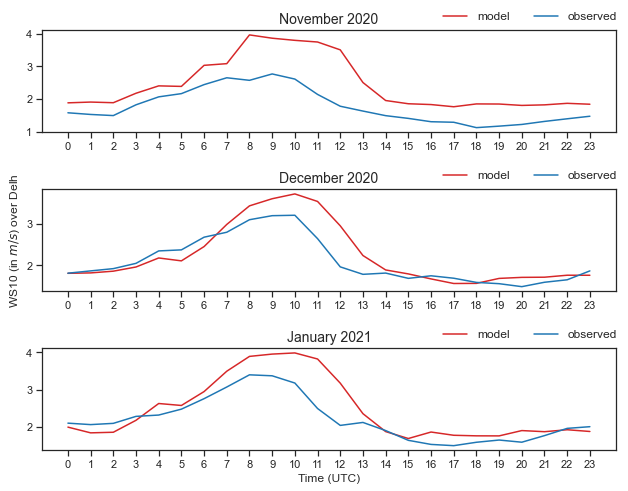

In [62]:
# Diurnal variation

fig = plt.figure(figsize=(9,7))

# plt.subplot(411)
# dplot.plot(df.interpolate(method='time', limit_area='inside'), df.interpolate(method='time', limit_area='inside'), 'mod_ws', 'obs_ws')
# # plt.ylabel('Wind Speed', fontsize=12)
# # plt.xlabel('Time (in hrs)', fontsize=12)
# plt.title('NDJ Combined', fontsize=14)

plt.subplot(311)
dplot.plot(dfnov.interpolate(method='time', limit_area='inside'), dfnov.interpolate(method='time', limit_area='inside'), 'mod_ws', 'obs_ws')
# plt.ylabel('Wind Speed', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(312)
dplot.plot(dfdec.interpolate(method='time', limit_area='inside'), dfdec.interpolate(method='time', limit_area='inside'), 'mod_ws', 'obs_ws')
plt.ylabel('WS10 (in $m/s$) over Delh', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(313)
dplot.plot(dfjan.interpolate(method='time', limit_area='inside'), dfjan.interpolate(method='time', limit_area='inside'), 'mod_ws', 'obs_ws')
# plt.ylabel('Wind Speed', fontsize=12)
plt.xlabel('Time (UTC)', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Wind Speed (in $m/s$) over Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/diurnal_ws.pdf', dpi=300)

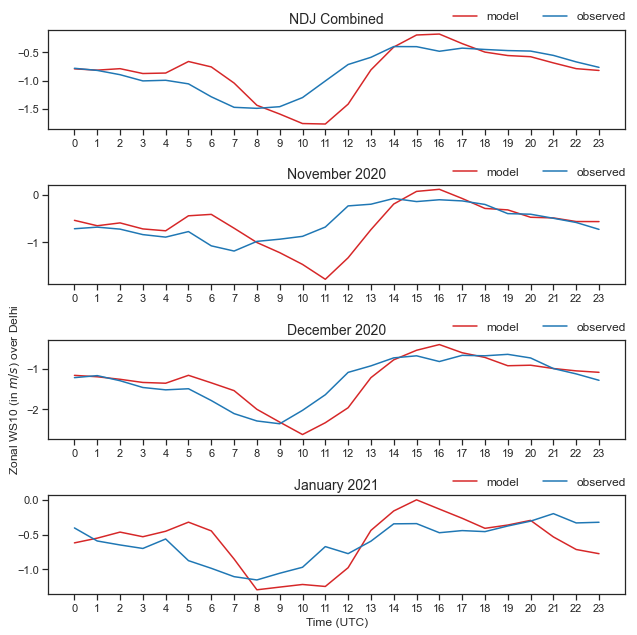

In [58]:
# Diurnal variation Zonal Wind

fig = plt.figure(figsize=(9,9))

plt.subplot(411)
dplot.plot(df.interpolate(method='time', limit_area='inside'), df.interpolate(method='time', limit_area='inside'), 'mod_zonal_wind', 'obs_zonal_wind')
# plt.ylabel('Wind Speed', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('NDJ Combined', fontsize=14)

plt.subplot(412)
dplot.plot(dfnov.interpolate(method='time', limit_area='inside'), dfnov.interpolate(method='time', limit_area='inside'), 'mod_zonal_wind', 'obs_zonal_wind')
# plt.ylabel('Wind Speed', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(413)
dplot.plot(dfdec.interpolate(method='time', limit_area='inside'), dfdec.interpolate(method='time', limit_area='inside'), 'mod_zonal_wind', 'obs_zonal_wind')
plt.ylabel('Zonal WS10 (in $m/s$) over Delhi', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(414)
dplot.plot(dfjan.interpolate(method='time', limit_area='inside'), dfjan.interpolate(method='time', limit_area='inside'), 'mod_zonal_wind', 'obs_zonal_wind')
# plt.ylabel('Wind Speed', fontsize=12)
plt.xlabel('Time (UTC)', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Zonal Wind Speed (in $m/s$) over Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/diurnal_zonal_wind.png', dpi=300)

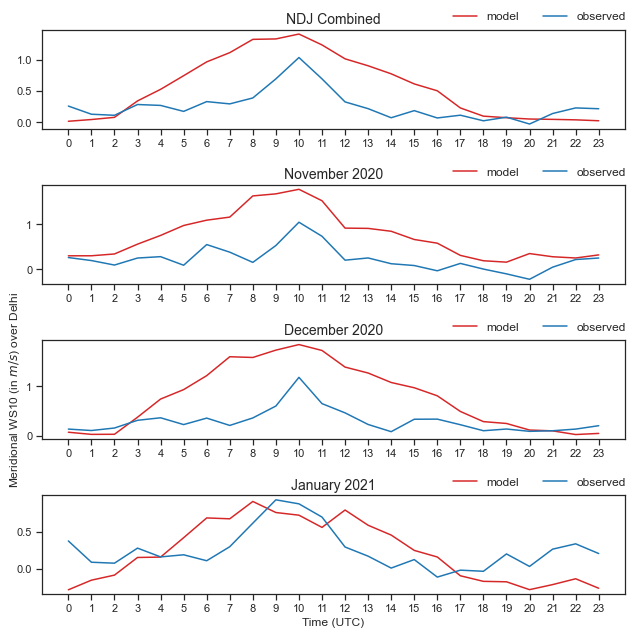

In [57]:
# Diurnal variation meridional Wind

fig = plt.figure(figsize=(9,9))

plt.subplot(411)
dplot.plot(df.interpolate(method='time', limit_area='inside'), df.interpolate(method='time', limit_area='inside'), 'mod_meridional_wind', 'obs_meridional_wind')
# plt.ylabel('Wind Speed', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('NDJ Combined', fontsize=14)

plt.subplot(412)
dplot.plot(dfnov.interpolate(method='time', limit_area='inside'), dfnov.interpolate(method='time', limit_area='inside'), 'mod_meridional_wind', 'obs_meridional_wind')
# plt.ylabel('Wind Speed', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(413)
dplot.plot(dfdec.interpolate(method='time', limit_area='inside'), dfdec.interpolate(method='time', limit_area='inside'), 'mod_meridional_wind', 'obs_meridional_wind')
plt.ylabel('Meridional WS10 (in $m/s$) over Delhi', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(414)
dplot.plot(dfjan.interpolate(method='time', limit_area='inside'), dfjan.interpolate(method='time', limit_area='inside'), 'mod_meridional_wind', 'obs_meridional_wind')
# plt.ylabel('Wind Speed', fontsize=12)
plt.xlabel('Time (UTC)', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Meridional Wind Speed (in $m/s$) over Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/diurnal_meridional_wind.pdf', dpi=300)

### Windrose plots for wind direction

Text(0.5, 1.0, 'November-Model')

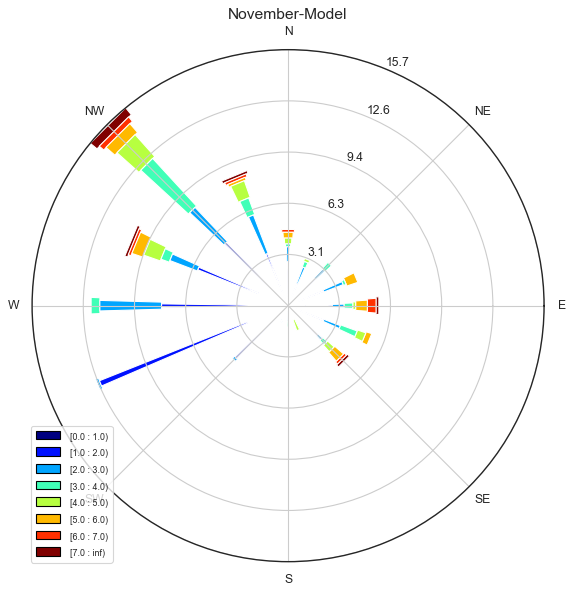

In [29]:
ax = WindroseAxes.from_ax()
# ax.bar(dfnov.mod_wd, dfnov.mod_ws, normed=False, opening=0.8, edgecolor='white')
# coordinates = ('E','NE','N','NW','W','SW','S','SE')
# ax.set_xticklabels(coordinates)
# ax.set_legend()
# ax.set_title('November-Model', fontsize=14)

ax.box(dfnov.mod_wd, dfnov.mod_ws, bins=np.arange(0, 8, 1), normed=True)
coordinates = ('E','NE','N','NW','W','SW','S','SE')
ax.set_xticklabels(coordinates)
ax.set_legend()
ax.set_title('November-Model', fontsize=14)

# ax.contourf(dfnov.mod_wd, dfnov.mod_ws, bins=np.arange(0, 8, 1), cmap=cm.hot)
# coordinates = ('E','NE','N','NW','W','SW','S','SE')
# ax.set_xticklabels(coordinates)
# ax.set_legend()
# ax.set_title('November-Model', fontsize=14)

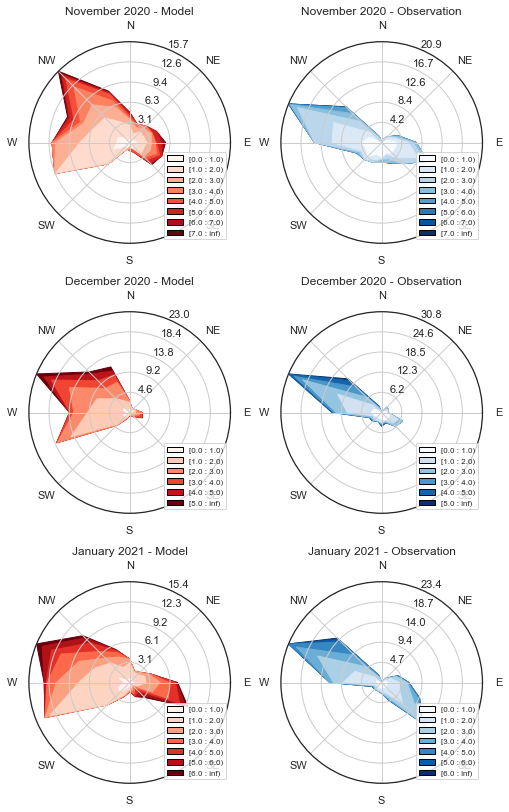

In [20]:
fig=plt.figure(figsize=(7,7.5))

rect1=[0.5,1.5,0.4,0.4] 
wa1=WindroseAxes(fig, rect1)
fig.add_axes(wa1)
wa1.contourf(dfnov.mod_wd, dfnov.mod_ws, bins=np.arange(0, 8, 1), cmap=cm.Reds, normed = True)
coordinates = ('E','NE','N','NW','W','SW','S','SE')
wa1.set_xticklabels(coordinates)
wa1.set_legend()
plt.legend(loc = 'lower right', prop={'size': 8})
wa1.set_title('November 2020 - Model', fontsize=12)

rect2 = [1.0,1.5,0.4,0.4]
wa2=WindroseAxes(fig, rect2)
fig.add_axes(wa2)
wa2.contourf(dfnov.obs_wd, dfnov.obs_ws, bins=np.arange(0, 8, 1), cmap=cm.Blues, normed = True)
coordinates = ('E','NE','N','NW','W','SW','S','SE')
wa2.set_xticklabels(coordinates)
wa2.set_legend()
plt.legend(loc = 'lower right', prop={'size': 8})
wa2.set_title('November 2020 - Observation', fontsize=12)

rect3=[0.5,1.0,0.4,0.4] 
wa3=WindroseAxes(fig, rect3)
fig.add_axes(wa3)
wa3.contourf(dfdec.mod_wd, dfdec.mod_ws, bins=np.arange(0, 6, 1), cmap=cm.Reds, normed = True)
coordinates = ('E','NE','N','NW','W','SW','S','SE')
wa3.set_xticklabels(coordinates)
wa3.set_legend()
plt.legend(loc = 'lower right', prop={'size': 8})
wa3.set_title('December 2020 - Model', fontsize=12)

rect4 = [1.0,1.0,0.4,0.4]
wa4=WindroseAxes(fig, rect4)
fig.add_axes(wa4)
wa4.contourf(dfdec.obs_wd, dfdec.obs_ws, bins=np.arange(0, 6, 1), cmap=cm.Blues, normed=True)
coordinates = ('E','NE','N','NW','W','SW','S','SE')
wa4.set_xticklabels(coordinates)
wa4.set_legend()
plt.legend(loc = 'lower right', prop={'size': 8})
wa4.set_title('December 2020 - Observation', fontsize=12)

rect5=[0.5,0.5,0.4,0.4] 
wa5=WindroseAxes(fig, rect5)
fig.add_axes(wa5)
wa5.contourf(dfjan.mod_wd, dfjan.mod_ws, bins=np.arange(0, 7, 1), cmap=cm.Reds, normed=True)
coordinates = ('E','NE','N','NW','W','SW','S','SE')
wa5.set_xticklabels(coordinates)
wa5.set_legend()
plt.legend(loc = 'lower right', prop={'size': 8})
wa5.set_title('January 2021 - Model', fontsize=12)

rect6 = [1.0,0.5,0.4,0.4]
wa6=WindroseAxes(fig, rect6)
fig.add_axes(wa6)
wa6.contourf(dfjan.obs_wd, dfjan.obs_ws, bins=np.arange(0, 7, 1), cmap=cm.Blues, normed=True)
coordinates = ('E','NE','N','NW','W','SW','S','SE')
wa6.set_xticklabels(coordinates)
wa6.set_legend()
plt.legend(loc = 'lower right', prop={'size': 8})
wa6.set_title('January 2021 - Observation', fontsize=12)

# fig.suptitle('Wind Rose Delhi', fontsize=24, y=2.0)
plt.savefig('./images/met_data/wind_rose.pdf', dpi=300) 

##### Manualy save the image ##########

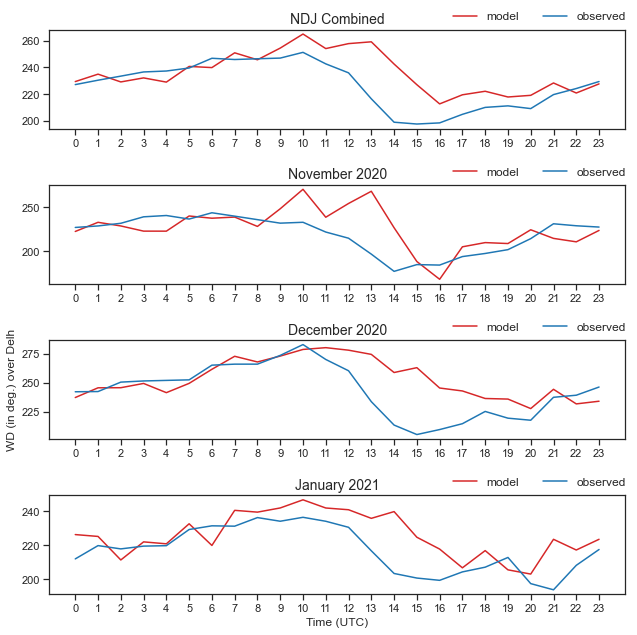

In [56]:
# Diurnal variation wd

fig = plt.figure(figsize=(9,9))

plt.subplot(411)
dplot.plot(df.interpolate(method='time', limit_area='inside'), df.interpolate(method='time', limit_area='inside'), 'mod_wd', 'obs_wd')
# plt.ylabel('Wind Speed', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('NDJ Combined', fontsize=14)

plt.subplot(412)
dplot.plot(dfnov.interpolate(method='time', limit_area='inside'), dfnov.interpolate(method='time', limit_area='inside'), 'mod_wd', 'obs_wd')
# plt.ylabel('Wind Speed', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(413)
dplot.plot(dfdec.interpolate(method='time', limit_area='inside'), dfdec.interpolate(method='time', limit_area='inside'), 'mod_wd', 'obs_wd')
plt.ylabel('WD (in deg.) over Delh', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(414)
dplot.plot(dfjan.interpolate(method='time', limit_area='inside'), dfjan.interpolate(method='time', limit_area='inside'), 'mod_wd', 'obs_wd')
# plt.ylabel('Wind Speed', fontsize=12)
plt.xlabel('Time (UTC)', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Wind Speed (in $m/s$) over Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/diurnal_wd.pdf', dpi=300)

# SW radiation plot (Downward) 

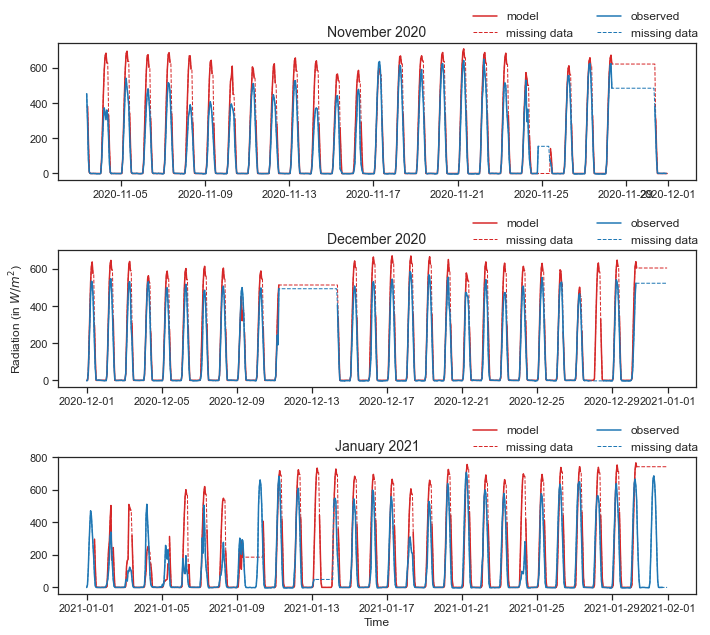

In [48]:
## Plot Downwelling Short-wave radiation for 3 months

fig = plt.figure(figsize=(10,9))
plt.subplot(311)
plt.plot(dfnov.index, dfnov['mod_swdown'], label='model', color='tab:red', ls='solid')
plt.plot(dfnov.index, dfnov['mod_swdown'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfnov.index, dfnov['obs_swupper'], label='observed', color='tab:blue')
plt.plot(dfnov.index, dfnov['obs_swupper'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
# plt.ylabel('Radiation (in $W/m^2$)', fontsize=12)
# plt.xlabel('Time', fontsize=12)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.title('November 2020', fontsize=14)

plt.subplot(312)
plt.plot(dfdec.index, dfdec['mod_swdown'], label='model', color='tab:red', ls='solid')
plt.plot(dfdec.index, dfdec['mod_swdown'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfdec.index, dfdec['obs_swupper'], label='observed', color='tab:blue')
plt.plot(dfdec.index, dfdec['obs_swupper'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
plt.ylabel('Radiation (in $W/m^2$)', fontsize=12)
# plt.xlabel('Time', fontsize=12)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.title('December 2020', fontsize=14)

plt.subplot(313)
plt.plot(dfjan.index, dfjan['mod_swdown'], label='model', color='tab:red', ls='solid')
plt.plot(dfjan.index, dfjan['mod_swdown'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:red')
# plt.xticks(rotation= 10)
plt.plot(dfjan.index, dfjan['obs_swupper'], label='observed', color='tab:blue')
plt.plot(dfjan.index, dfjan['obs_swupper'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='tab:blue')
#plt.xticks(rotation= 10)
# plt.ylabel('Radiation (in $W/m^2$)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(ncol=2, frameon=False, loc='right', bbox_to_anchor=(1.02, 1.13), prop={'size': 12})
plt.title('January 2021', fontsize=14)

# fig.suptitle('Downwelling Shortwave Radiation in Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/swdown.pdf', dpi=300)

In [153]:
# ## Plot Downwelling Short-wave radiation for 3 months with swlower

# fig = plt.figure(figsize=(20,15))
# plt.subplot(311)
# plt.plot(dfnov.index, dfnov['mod_swdown'], label='model', color='red', ls='solid')
# plt.plot(dfnov.index, dfnov['mod_swdown'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='red')
# # plt.xticks(rotation= 10)
# plt.plot(dfnov.index, dfnov['obs_swlower'], label='observed', color='blue')
# plt.plot(dfnov.index, dfnov['obs_swlower'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='blue')
# #plt.xticks(rotation= 10)
# plt.ylabel('Radiation (in $W/m^2$)', fontsize=14)
# plt.xlabel('Time', fontsize=14)
# plt.legend(loc=1, prop={'size': 14})
# plt.title('November 2020', fontsize=18)

# plt.subplot(312)
# plt.plot(dfdec.index, dfdec['mod_swdown'], label='model', color='red', ls='solid')
# plt.plot(dfdec.index, dfdec['mod_swdown'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='red')
# # plt.xticks(rotation= 10)
# plt.plot(dfdec.index, dfdec['obs_swlower'], label='observed', color='blue')
# plt.plot(dfdec.index, dfdec['obs_swlower'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='blue')
# #plt.xticks(rotation= 10)
# plt.ylabel('Radiation (in $W/m^2$)', fontsize=14)
# plt.xlabel('Time', fontsize=14)
# plt.legend(loc=1, prop={'size': 14})
# plt.title('December 2020', fontsize=18)

# plt.subplot(313)
# plt.plot(dfjan.index, dfjan['mod_swdown'], label='model', color='red', ls='solid')
# plt.plot(dfjan.index, dfjan['mod_swdown'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='red')
# # plt.xticks(rotation= 10)
# plt.plot(dfjan.index, dfjan['obs_swlower'], label='observed', color='blue')
# plt.plot(dfjan.index, dfjan['obs_swlower'].fillna(method='ffill'), ls = '--', lw = 1, label='missing data', color='blue')
# #plt.xticks(rotation= 10)
# plt.ylabel('Radiation (in $W/m^2$)', fontsize=14)
# plt.xlabel('Time', fontsize=14)
# plt.legend(loc=1, prop={'size': 14})
# plt.title('January 2021', fontsize=18)

# fig.suptitle('Downwelling Shortwave Radiation in Delhi', fontsize=24, y=0.99)
# fig.tight_layout()
# plt.savefig('./images/met_data/swdown2.png')

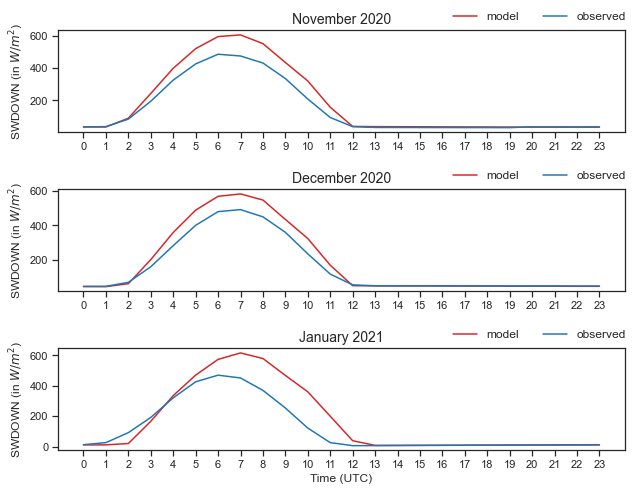

In [63]:
# Diurnal variation

fig = plt.figure(figsize=(9,7))

# plt.subplot(411)
# dplot.plot(df.interpolate(method='time', limit_area='inside'), df.interpolate(method='time', limit_area='inside'), 'mod_swdown', 'obs_swupper')
# # plt.ylabel('Downwelling SW Radiation', fontsize=12)
# # plt.xlabel('Time (in hrs)', fontsize=12)
# plt.title('NDJ Combined', fontsize=14)

plt.subplot(311)
dplot.plot(dfnov.interpolate(method='time', limit_area='inside'), dfnov.interpolate(method='time', limit_area='inside'), 'mod_swdown', 'obs_swupper')
plt.ylabel('SWDOWN (in $W/m^2$)', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(312)
dplot.plot(dfdec.interpolate(method='time', limit_area='inside'), dfdec.interpolate(method='time', limit_area='inside'), 'mod_swdown', 'obs_swupper')
plt.ylabel('SWDOWN (in $W/m^2$)', fontsize=12)
# plt.xlabel('Time (in hrs)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(313)
dplot.plot(dfjan.interpolate(method='time', limit_area='inside'), dfjan.interpolate(method='time', limit_area='inside'), 'mod_swdown', 'obs_swupper')
plt.ylabel('SWDOWN (in $W/m^2$)', fontsize=12)
plt.xlabel('Time (UTC)', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Downwelling Shortwave radiation (in $W/m^2$) over Delhi', fontsize=24, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/diurnal_swdown.pdf', dpi=300)

### The combined diurnal plot of T2, SWDOWN and WS10 for the main paper, the WD one goes in supplementary and others as well.

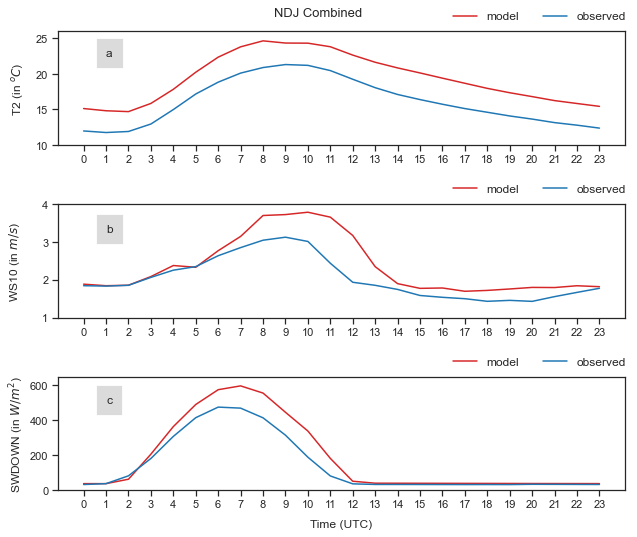

In [83]:
# Diurnal variation (main)

fig = plt.figure(figsize=(9,8))

plt.subplot(311)
dplot.plot(df, df, 'mod_temp', 'obs_temp')
plt.ylabel('T2 (in $^{o}C$)', fontsize=12, labelpad=10)
plt.ylim(10, 26)
# plt.xlabel('Time (in hrs)', fontsize=14)
# plt.title('NDJ Combined', fontsize=13)
plt.text(1, 22.5, 'a', style='normal', fontsize=12, bbox={'facecolor': 'lightgray', 'alpha': 0.8, 'pad': 10})

plt.subplot(312)
dplot.plot(df.interpolate(method='time', limit_area='inside'), df.interpolate(method='time', limit_area='inside'), 'mod_ws', 'obs_ws')
plt.ylabel('WS10 (in $m/s$)', fontsize=12, labelpad=20)
plt.ylim(1, 4)
# plt.xlabel('Time (in hrs)', fontsize=12)
# plt.title('b', fontsize=13)
plt.text(1, 3.25, 'b', style='normal', fontsize=12, bbox={'facecolor': 'lightgray', 'alpha': 0.8, 'pad': 10})

plt.subplot(313)
dplot.plot(df.interpolate(method='time', limit_area='inside'), df.interpolate(method='time', limit_area='inside'), 'mod_swdown', 'obs_swupper')
plt.ylabel('SWDOWN (in $W/m^2$)', fontsize=12)
plt.ylim(0, 650)
plt.xlabel('Time (UTC)', fontsize=12, labelpad=10)
# plt.title('c', fontsize=13)
plt.text(1, 500, 'c', style='normal', fontsize=12, bbox={'facecolor': 'lightgray', 'alpha': 0.8, 'pad': 10})

fig.suptitle('NDJ Combined', fontsize=13, y = 0.93)
fig.tight_layout()
plt.savefig('./images/met_data/diurnal_main.pdf', dpi=300)

### Calculation of statistical performance

#### November

In [21]:
# Temperature
stat_calc.get_stat_performance(dfnov[['mod_temp', 'obs_temp']].dropna())

Enter the column for model value:  mod_temp
Enter the column for observation value:  obs_temp


Mean bias :
mean bias 2.996370083056479
fractional bias is :
fractional bias =  0.13913602492132024
Correlation coefficient is :
corr coeff =  0.9588225964009626  and p-value is =  0.0
RMSE is :
RMSE  3.210589484618314
NMSE is :
NMSE  0.02233391185278498


In [22]:
# SWdown
stat_calc.get_stat_performance(dfnov[['mod_swdown', 'obs_swupper']].dropna())

Enter the column for model value:  mod_swdown
Enter the column for observation value:  obs_swupper


Mean bias :
mean bias 35.31734086805557
fractional bias is :
fractional bias =  0.26807429376819847
Correlation coefficient is :
corr coeff =  0.9758080789480882  and p-value is =  0.0
RMSE is :
RMSE  73.85228223109476
NMSE is :
NMSE  0.31998943908815936


In [27]:
# WS
stat_calc.get_stat_performance(dfnov[['mod_ws','obs_ws']].dropna())

Enter the column for model value:  mod_ws
Enter the column for observation value:  obs_ws


Mean bias :
mean bias 0.6184035034722216
fractional bias is :
fractional bias =  0.32004447200505465
Correlation coefficient is :
corr coeff =  0.7118048042636598  and p-value is =  3.987159087986373e-90
RMSE is :
RMSE  1.241016264602549
NMSE is :
NMSE  0.4233481056447396


In [29]:
# WD
stat_calc.get_stat_performance(dfnov[['mod_wd','obs_wd']].dropna())

Enter the column for model value:  mod_wd
Enter the column for observation value:  obs_wd


Mean bias :
mean bias 9.162879240506324
fractional bias is :
fractional bias =  0.04202565891248711
Correlation coefficient is :
corr coeff =  0.5609815100964536  and p-value is =  3.6780877356907015e-47
RMSE is :
RMSE  90.02287647914856
NMSE is :
NMSE  0.1705543138895391


#### December

In [30]:
# Temperature
stat_calc.get_stat_performance(dfdec[['mod_temp','obs_temp']].dropna())

Enter the column for model value:  mod_temp
Enter the column for observation value:  obs_temp


Mean bias :
mean bias 2.9716905716612385
fractional bias is :
fractional bias =  0.17250362834994415
Correlation coefficient is :
corr coeff =  0.9690193630435879  and p-value is =  0.0
RMSE is :
RMSE  3.2608752904015064
NMSE is :
NMSE  0.03609945397129635


In [32]:
# SWdown
stat_calc.get_stat_performance(dfdec[['mod_swdown','obs_swupper']].dropna())

Enter the column for model value:  mod_swdown
Enter the column for observation value:  obs_swupper


Mean bias :
mean bias 27.308171513605448
fractional bias is :
fractional bias =  0.21581468208301696
Correlation coefficient is :
corr coeff =  0.9880848942512716  and p-value is =  0.0
RMSE is :
RMSE  54.84542482924812
NMSE is :
NMSE  0.19008337483779056


In [34]:
# WS
stat_calc.get_stat_performance(dfdec[['mod_ws','obs_ws']].dropna())

Enter the column for model value:  mod_ws
Enter the column for observation value:  obs_ws


Mean bias :
mean bias 0.24735524584040802
fractional bias is :
fractional bias =  0.12376551533712613
Correlation coefficient is :
corr coeff =  0.7282557793789304  and p-value is =  2.082129352073685e-98
RMSE is :
RMSE  0.8928116051719951
NMSE is :
NMSE  0.20032863181880378


In [35]:
# WD
stat_calc.get_stat_performance(dfdec[['mod_wd','obs_wd']].dropna())

Enter the column for model value:  mod_wd
Enter the column for observation value:  obs_wd


Mean bias :
mean bias 20.502105161290327
fractional bias is :
fractional bias =  0.08277923545322197
Correlation coefficient is :
corr coeff =  0.40254173855113096  and p-value is =  2.3710993481812845e-24
RMSE is :
RMSE  87.86047439595785
NMSE is :
NMSE  0.12606009326461642


#### January

In [36]:
# Temperature
stat_calc.get_stat_performance(dfjan[['mod_temp','obs_temp']].dropna())

Enter the column for model value:  mod_temp
Enter the column for observation value:  obs_temp


Mean bias :
mean bias 3.5359927100632724
fractional bias is :
fractional bias =  0.23429302433708632
Correlation coefficient is :
corr coeff =  0.8304889420976805  and p-value is =  2.613138200785413e-166
RMSE is :
RMSE  4.129059355069105
NMSE is :
NMSE  0.0758926077028061


In [38]:
# SWdown
stat_calc.get_stat_performance(dfjan[['mod_swdown','obs_swupper']].dropna())

Enter the column for model value:  mod_swdown
Enter the column for observation value:  obs_swupper


Mean bias :
mean bias 40.54751516037326
fractional bias is :
fractional bias =  0.3240786520164145
Correlation coefficient is :
corr coeff =  0.8831301804534388  and p-value is =  1.227576218185378e-205
RMSE is :
RMSE  117.4553540667614
NMSE is :
NMSE  0.9050519977877785


In [39]:
# WS
stat_calc.get_stat_performance(dfjan[['mod_ws','obs_ws']].dropna())

Enter the column for model value:  mod_ws
Enter the column for observation value:  obs_ws


Mean bias :
mean bias 0.18347173469790665
fractional bias is :
fractional bias =  0.08074947786845163
Correlation coefficient is :
corr coeff =  0.48784119378191043  and p-value is =  1.916144776181434e-38
RMSE is :
RMSE  1.3563548200271618
NMSE is :
NMSE  0.3569408643960633


In [42]:
# WD
stat_calc.get_stat_performance(dfjan[['mod_wd','obs_wd']].dropna())

Enter the column for model value:  mod_wd
Enter the column for observation value:  obs_wd


Mean bias :
mean bias 6.8747468374396234
fractional bias is :
fractional bias =  0.031696130621954935
Correlation coefficient is :
corr coeff =  0.5924784406193674  and p-value is =  4.124183857022356e-60
RMSE is :
RMSE  82.61426253692655
NMSE is :
NMSE  0.14511697893783412


#### Combined

In [43]:
# Temperature
stat_calc.get_stat_performance(df[['mod_temp','obs_temp']].dropna())

Enter the column for model value:  mod_temp
Enter the column for observation value:  obs_temp


Mean bias :
mean bias 3.175834805322422
fractional bias is :
fractional bias =  0.1776562599562861
Correlation coefficient is :
corr coeff =  0.9471061902515174  and p-value is =  0.0
RMSE is :
RMSE  3.571918565003118
NMSE is :
NMSE  0.04024284575245834


In [44]:
# SWdown
stat_calc.get_stat_performance(df[['mod_swdown','obs_swupper']].dropna())

Enter the column for model value:  mod_swdown
Enter the column for observation value:  obs_swupper


Mean bias :
mean bias 34.49859949837076
fractional bias is :
fractional bias =  0.2701056733994913
Correlation coefficient is :
corr coeff =  0.945830822428522  and p-value is =  0.0
RMSE is :
RMSE  86.89308648603082
NMSE is :
NMSE  0.4714430889345139


In [45]:
# WS
stat_calc.get_stat_performance(df[['mod_ws','obs_ws']].dropna())

Enter the column for model value:  mod_ws
Enter the column for observation value:  obs_ws


Mean bias :
mean bias 0.3448088494106378
fractional bias is :
fractional bias =  0.16638999121133213
Correlation coefficient is :
corr coeff =  0.6181241014441152  and p-value is =  9.951982363191038e-189
RMSE is :
RMSE  1.182899315682556
NMSE is :
NMSE  0.3281024942518604


In [46]:
# WD
stat_calc.get_stat_performance(df[['mod_wd','obs_wd']].dropna())

Enter the column for model value:  mod_wd
Enter the column for observation value:  obs_wd


Mean bias :
mean bias 12.145224019313675
fractional bias is :
fractional bias =  0.0533777014484538
Correlation coefficient is :
corr coeff =  0.5399611987263593  and p-value is =  5.481814130010665e-134
RMSE is :
RMSE  86.74729196978474
NMSE is :
NMSE  0.14545544556846957


In [85]:
### Geting the individual dataframes for qqplot and rplot

temp = df[['mod_temp', 'obs_temp']]
temp_nov = dfnov[['mod_temp', 'obs_temp']]
temp_dec = dfdec[['mod_temp', 'obs_temp']]
temp_jan = dfjan[['mod_temp', 'obs_temp']]

swdown = df[['mod_swdown', 'obs_swupper']]
swdown_nov = dfnov[['mod_swdown', 'obs_swupper']]
swdown_dec = dfdec[['mod_swdown', 'obs_swupper']]
swdown_jan = dfjan[['mod_swdown', 'obs_swupper']]

wd = df[['mod_wd', 'obs_wd']]
wd_nov = dfnov[['mod_wd', 'obs_wd']]
wd_dec = dfdec[['mod_wd', 'obs_wd']]
wd_jan = dfjan[['mod_wd', 'obs_wd']]

ws = df[['mod_ws', 'obs_ws']]
ws_nov = dfnov[['mod_ws', 'obs_ws']]
ws_dec = dfdec[['mod_ws', 'obs_ws']]
ws_jan = dfjan[['mod_ws', 'obs_ws']]

### QQ-plot

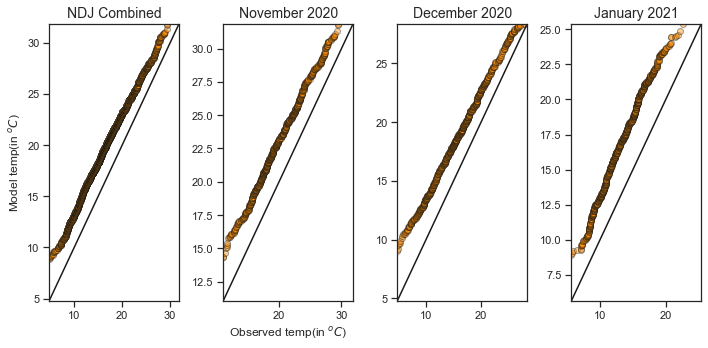

In [86]:
# Temperature

fig = plt.figure(figsize=(10,5))

plt.subplot(141)
qqplot.plot(temp.dropna()['obs_temp'], temp.dropna()['mod_temp'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed temp', fontsize=12)
plt.ylabel('Model temp(in $^{o}C$)', fontsize=12)
plt.title('NDJ Combined',fontsize=14)

plt.subplot(142)
qqplot.plot(temp_nov.dropna()['obs_temp'], temp_nov.dropna()['mod_temp'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
plt.xlabel('Observed temp(in $^{o}C$)', fontsize=12)
# plt.ylabel('Model temp', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(143)
qqplot.plot(temp_dec.dropna()['obs_temp'], temp_dec.dropna()['mod_temp'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed temp(in $^{o}C$)', fontsize=12)
# plt.ylabel('Model temp', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(144)
qqplot.plot(temp_jan.dropna()['obs_temp'], temp_jan.dropna()['mod_temp'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed temp', fontsize=12)
# plt.ylabel('Model temp', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Q-Q Plot for 2$m$ Temperature (in $^{o}C$) in Delhi', fontsize=27, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/qqplot_temp.pdf', dpi=300)

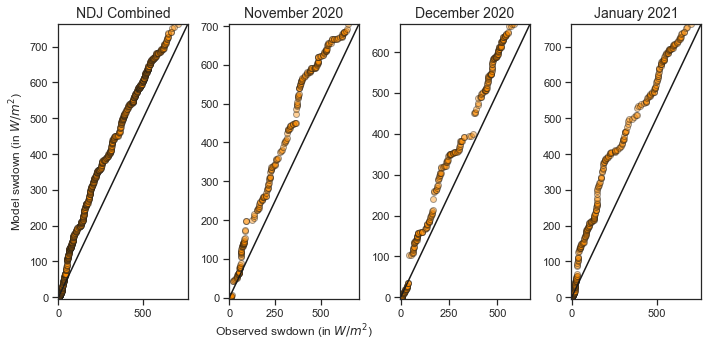

In [87]:
# SWDOWN

fig = plt.figure(figsize=(10,5))

plt.subplot(141)
qqplot.plot(swdown.dropna()['obs_swupper'], swdown.dropna()['mod_swdown'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed swdown', fontsize=12)
plt.ylabel('Model swdown (in $W/m^2$)', fontsize=12)
plt.title('NDJ Combined',fontsize=14)

plt.subplot(142)
qqplot.plot(swdown_nov.dropna()['obs_swupper'], swdown_nov.dropna()['mod_swdown'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
plt.xlabel('Observed swdown (in $W/m^2$)', fontsize=12)
# plt.ylabel('Model swdown', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(143)
qqplot.plot(swdown_dec.dropna()['obs_swupper'], swdown_dec.dropna()['mod_swdown'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed swdown', fontsize=12)
# plt.ylabel('Model swdown', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(144)
qqplot.plot(swdown_jan.dropna()['obs_swupper'], swdown_jan.dropna()['mod_swdown'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed swdown', fontsize=12)
# plt.ylabel('Model swdown', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Q-Q Plot for Downwelling shortwave radiation (in $W/m^2$) in Delhi', fontsize=27, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/qqplot_swdown.pdf', dpi=300)

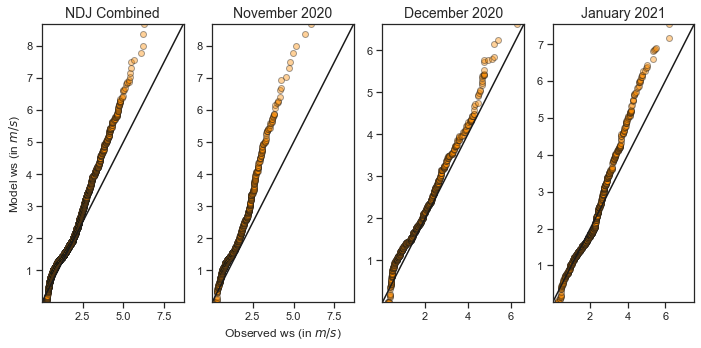

In [88]:
# ws

fig = plt.figure(figsize=(10,5))

plt.subplot(141)
qqplot.plot(ws.dropna()['obs_ws'], ws.dropna()['mod_ws'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed ws ', fontsize=12)
plt.ylabel('Model ws (in $m/s$)', fontsize=12)
plt.title('NDJ Combined',fontsize=14)

plt.subplot(142)
qqplot.plot(ws_nov.dropna()['obs_ws'], ws_nov.dropna()['mod_ws'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
plt.xlabel('Observed ws (in $m/s$)', fontsize=12)
# plt.ylabel('Model ws', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(143)
qqplot.plot(ws_dec.dropna()['obs_ws'], ws_dec.dropna()['mod_ws'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed ws', fontsize=12)
# plt.ylabel('Model ws', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(144)
qqplot.plot(ws_jan.dropna()['obs_ws'], ws_jan.dropna()['mod_ws'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed ws', fontsize=12)
# plt.ylabel('Model ws', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Q-Q Plot for Wind speed (in $m/s$) in Delhi', fontsize=27, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/qqplot_ws.pdf', dpi=300)

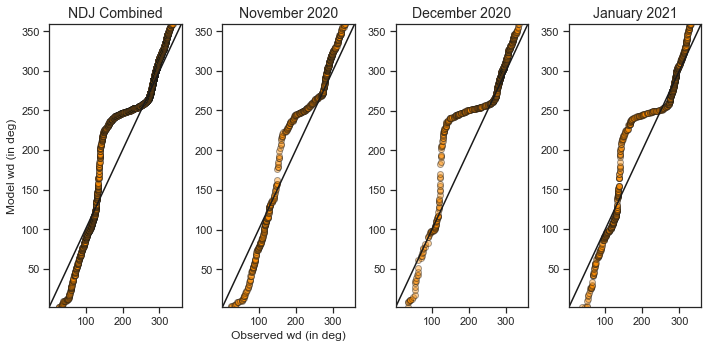

In [89]:
# wd

fig = plt.figure(figsize=(10,5))

plt.subplot(141)
qqplot.plot(wd.dropna()['obs_wd'], wd.dropna()['mod_wd'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed wd', fontsize=12)
plt.ylabel('Model wd (in deg)', fontsize=12)
plt.title('NDJ Combined',fontsize=14)

plt.subplot(142)
qqplot.plot(wd_nov.dropna()['obs_wd'], wd_nov.dropna()['mod_wd'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
plt.xlabel('Observed wd (in deg)', fontsize=12)
# plt.ylabel('Model wd', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(143)
qqplot.plot(wd_dec.dropna()['obs_wd'], wd_dec.dropna()['mod_wd'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed wd', fontsize=12)
# plt.ylabel('Model wd', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(144)
qqplot.plot(wd_jan.dropna()['obs_wd'], wd_jan.dropna()['mod_wd'], c='darkorange', alpha=0.4, edgecolor='k', rug=False)
# plt.xlabel('Observed wd', fontsize=12)
# plt.ylabel('Model wd', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Q-Q Plot for Wind Direction (in deg) in Delhi', fontsize=27, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/qqplot_wd.pdf', dpi=300)

### Scatter-correlation plot

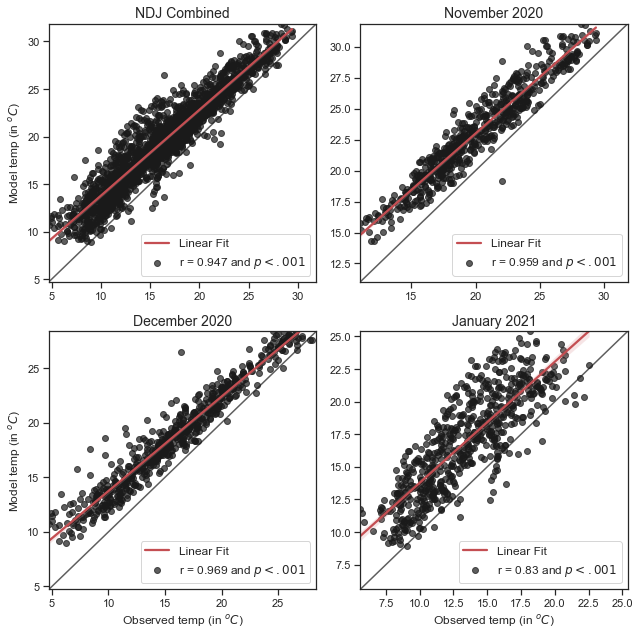

In [90]:
# Temperature

fig = plt.figure(figsize=(9,9))

plt.subplot(221)
rplot.plot(temp, temp.dropna()['obs_temp'], temp.dropna()['mod_temp'], color='k', alpha=0.7)
# plt.xlabel('Observed temp', fontsize=12)
plt.ylabel('Model temp (in $^{o}C$)', fontsize=12)
plt.title('NDJ Combined',fontsize=14)

plt.subplot(222)
rplot.plot(temp_nov, temp_nov.dropna()['obs_temp'], temp_nov.dropna()['mod_temp'], color='k', alpha=0.7)
# plt.xlabel('Observed temp', fontsize=12)
# plt.ylabel('Model temp (in $^{o}C$)', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(223)
rplot.plot(temp_dec, temp_dec.dropna()['obs_temp'], temp_dec.dropna()['mod_temp'], color='k', alpha=0.7)
plt.xlabel('Observed temp (in $^{o}C$)', fontsize=12)
plt.ylabel('Model temp (in $^{o}C$)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(224)
rplot.plot(temp_jan, temp_jan.dropna()['obs_temp'], temp_jan.dropna()['mod_temp'], color='k', alpha=0.7)
plt.xlabel('Observed temp (in $^{o}C$)', fontsize=12)
# plt.ylabel('Model temp', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Scatter Plots for 2$m$ Temperature (in $^{o}C$) in Delhi', fontsize=27, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/rplot_temp.pdf', dpi=300)

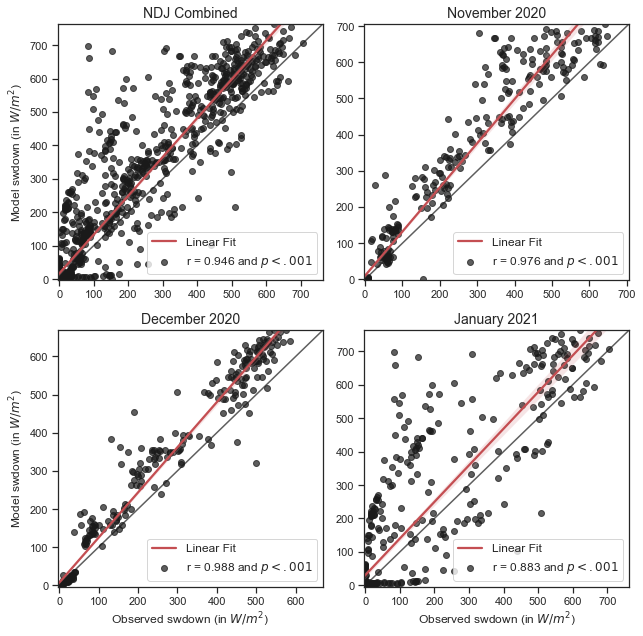

In [91]:
# Downwelling Shortwave radiation

fig = plt.figure(figsize=(9,9))

plt.subplot(221)
rplot.plot(swdown, swdown.dropna()['obs_swupper'], swdown.dropna()['mod_swdown'], color='k', alpha=0.7)
# plt.xlabel('Observed swdown', fontsize=12)
plt.ylabel('Model swdown (in $W/m^2$)', fontsize=12)
plt.title('NDJ Combined',fontsize=14)

plt.subplot(222)
rplot.plot(swdown_nov, swdown_nov.dropna()['obs_swupper'], swdown_nov.dropna()['mod_swdown'], color='k', alpha=0.7)
# plt.xlabel('Observed swdown', fontsize=12)
# plt.ylabel('Model swdown', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(223)
rplot.plot(swdown_dec, swdown_dec.dropna()['obs_swupper'], swdown_dec.dropna()['mod_swdown'], color='k', alpha=0.7)
plt.xlabel('Observed swdown (in $W/m^2$)', fontsize=12)
plt.ylabel('Model swdown (in $W/m^2$)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(224)
rplot.plot(swdown_jan, swdown_jan.dropna()['obs_swupper'], swdown_jan.dropna()['mod_swdown'], color='k', alpha=0.7)
plt.xlabel('Observed swdown (in $W/m^2$)', fontsize=12)
# plt.ylabel('Model swdown', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Scatter Plots for Downwelling shortwave radiation (in $W/m^2$) in Delhi', fontsize=27, y=0.99)
# fig.suptitle('for 2$m$ Downwelling Shortwave radiation (in $^{o}C$) in Delhi', fontsize=27, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/rplot_swdown.pdf', dpi=300)

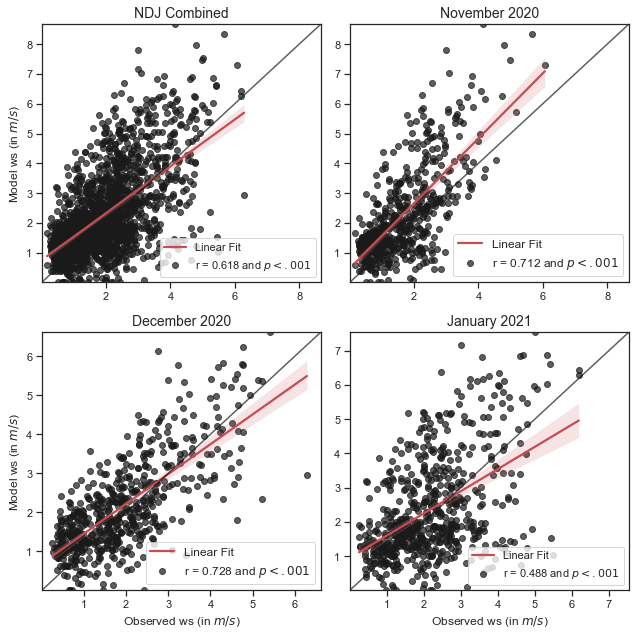

In [94]:
# Wind Speed

fig = plt.figure(figsize=(9,9))

plt.subplot(221)
rplot.plot(ws, ws.dropna()['obs_ws'], ws.dropna()['mod_ws'], color='k', alpha=0.7)
# plt.xlabel('Observed ws', fontsize=12)
plt.ylabel('Model ws (in $m/s$)', fontsize=12)
plt.title('NDJ Combined',fontsize=14)
plt.legend(loc=4)

plt.subplot(222)
rplot.plot(ws_nov, ws_nov.dropna()['obs_ws'], ws_nov.dropna()['mod_ws'], color='k', alpha=0.7)
# plt.xlabel('Observed ws', fontsize=12)
# plt.ylabel('Model ws', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(223)
rplot.plot(ws_dec, ws_dec.dropna()['obs_ws'], ws_dec.dropna()['mod_ws'], color='k', alpha=0.7)
plt.xlabel('Observed ws (in $m/s$)', fontsize=12)
plt.ylabel('Model ws (in $m/s$)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(224)
rplot.plot(ws_jan, ws_jan.dropna()['obs_ws'], ws_jan.dropna()['mod_ws'], color='k', alpha=0.7)
plt.xlabel('Observed ws (in $m/s$)', fontsize=12)
# plt.ylabel('Model ws', fontsize=12)
plt.legend(loc=4)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Scatter Plots for Wind speed (in $m/s$) in Delhi', fontsize=27, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/rplot_ws.pdf', dpi=300)

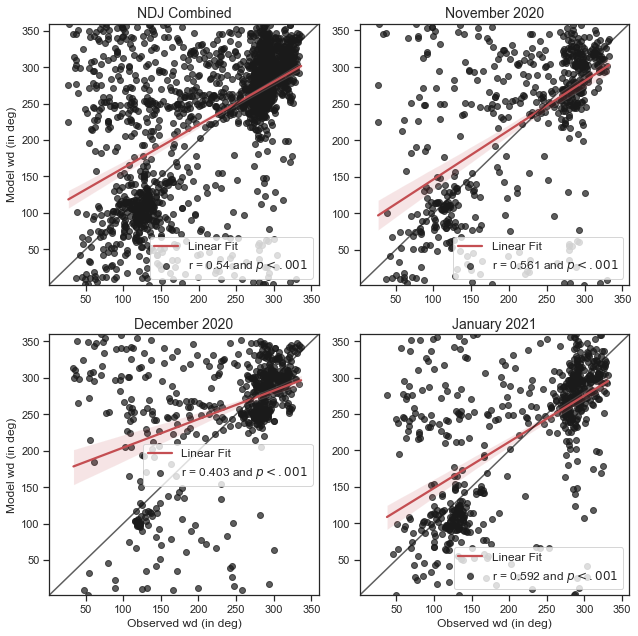

In [95]:
# Wind Direction

fig = plt.figure(figsize=(9,9))

plt.subplot(221)
rplot.plot(wd, wd.dropna()['obs_wd'], wd.dropna()['mod_wd'], color='k', alpha=0.7)
# plt.xlabel('Observed wd', fontsize=12)
plt.ylabel('Model wd (in deg)', fontsize=12)
plt.title('NDJ Combined',fontsize=14)

plt.subplot(222)
rplot.plot(wd_nov, wd_nov.dropna()['obs_wd'], wd_nov.dropna()['mod_wd'], color='k', alpha=0.7)
# plt.xlabel('Observed wd', fontsize=12)
# plt.ylabel('Model wd', fontsize=12)
plt.title('November 2020', fontsize=14)

plt.subplot(223)
rplot.plot(wd_dec, wd_dec.dropna()['obs_wd'], wd_dec.dropna()['mod_wd'], color='k', alpha=0.7)
plt.xlabel('Observed wd (in deg)', fontsize=12)
plt.ylabel('Model wd (in deg)', fontsize=12)
plt.title('December 2020', fontsize=14)

plt.subplot(224)
rplot.plot(wd_jan, wd_jan.dropna()['obs_wd'], wd_jan.dropna()['mod_wd'], color='k', alpha=0.7)
plt.xlabel('Observed wd (in deg)', fontsize=12)
# plt.ylabel('Model wd', fontsize=12)
plt.title('January 2021', fontsize=14)

# fig.suptitle('Scatter Plots for Wind Direction (in deg) in Delhi', fontsize=27, y=0.99)
fig.tight_layout()
plt.savefig('./images/met_data/rplot_wd.pdf', dpi=300)